# Level A Instructions:

### Some steps to get familiar with the system:

- Have a look at the rgb images in the folder "ARKitScenesData/47333473/47333473_frames/lowres_wide/" to get an impression of the scene that we are working with
- Run the notebook which will show example detection, full pipeline results, and interactive querying

## Level A

This lab demonstrates open-vocabulary 3D semantic mapping using SAM (Segment Anything Model) and CLIP (Contrastive Language-Image Pre-training) with RGB-D data from the ARKitScenes dataset.
Level A creates a semantic voxel grid where each voxel stores CLIP features, enabling text-based queries to find objects in 3D space without predefined classes.

## Requirements for passing Level A:
- Functional pipeline with semantic voxel grid construction
- Successful text-based queries returning reasonable results
- Understanding and explanation of rough code flow and steps required in pipeline execution

## Tips:
- In this level there is not much parameter tuning required, making the system functional by filling in code blocks and understanding/explaining the steps suffices to pass
- There is one codeblock where you are asked to reimplement a small portion using a more efficient approach by avoiding a for loop. There is a check to make sure that outputs are equivalent that should be passed.
- Given the somewhat higher computational expense to run the level A pipeline, by default a maximum of 40 images are processed here. Showing results for this portion is enough (see example images).
- You may consider to lower the max_frames parameter during development to a number < 40 for efficiency.

## 1. Dependencies and Imports


In [1]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
# Import required libraries
import os
from typing import Dict, List, Optional
import cv2
import numpy as np
from PIL import Image
import torch
from tqdm.notebook import tqdm

# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data
from lab_utils.tsdf_utils import build_tsdf_point_cloud
from lab_utils.model_loaders import load_sam_model, load_clip_model
from lab_utils.level_specific_viz import visualize_level_a_example, query_and_visualize_semantic_grid

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/jovyan/eai2025_lab2_perception/lab2/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 2. Configuration


In [14]:
class Config:
    # Scene Configuration
    SCENE_ID = "47333473"
    BASE_PATH = f"ARKitScenesData/{SCENE_ID}/{SCENE_ID}_frames"
    RGB_PATH = os.path.join(BASE_PATH, "lowres_wide")
    DEPTH_PATH = os.path.join(BASE_PATH, "lowres_depth")
    INTRINSICS_PATH = os.path.join(BASE_PATH, "lowres_wide_intrinsics")
    TRAJ_FILE_PATH = os.path.join(BASE_PATH, "lowres_wide.traj")
    
    # Level A Configuration
    LEVEL_A_CONFIG = {
        'frame_skip': 7,                                  
        'max_frames': 40,                                  
        'voxel_size': 0.1, # originally 0.1                                  
        'grid_size': 6,                                    
        'sam_confidence_threshold': 0.5,                   
        'clip_model': 'openai/clip-vit-base-patch32',      
        'example_viz_index': 29,                          
        'padding_ratio_image_crops': 0.1                   
    }
    
    # TSDF Configuration (for visualization)
    TSDF_CONFIG = {
        'frame_skip': 3,
        'depth_scale': 1000.0,
        'depth_trunc': 7.0,
        'voxel_size': 0.04,
        'batch_size': 20,
        'max_frames': 1000,
        'volume_length': 30.0,
        'resolution': 512,
    }
    
    # Rerun Viewer Dimensions
    RERUN_WIDTH, RERUN_HEIGHT = 1200, 700

# Create and validate config
config = Config()

## 3. Execution Functions

These functions orchestrate the different parts of the pipeline:

In [15]:
def run_example_visualization(config: Config) -> Dict:
    """Execute example visualization."""
    print("=" * 60)
    print("EXAMPLE VISUALIZATION")
    print("=" * 60)
    
    example_results = visualize_level_a_example(
        config,
        frame_index=config.LEVEL_A_CONFIG['example_viz_index']
    )
    
    print("Example visualization complete!")
    return example_results


def run_full_pipeline(config: Config) -> Dict:
    """Execute the complete semantic voxel mapping pipeline."""
    print("\n" + "=" * 60)
    print("FULL PIPELINE EXECUTION")
    print("=" * 60)
    
    level_a_results = run_level_a_pipeline(
        config,
        max_frames=config.LEVEL_A_CONFIG['max_frames'],
        voxel_size=config.LEVEL_A_CONFIG['voxel_size'],
        grid_size=config.LEVEL_A_CONFIG['grid_size'],
        frame_skip_level_a=config.LEVEL_A_CONFIG['frame_skip']
    )
    
    if level_a_results and 'voxel_grid' in level_a_results:
        print(f"\nSemantic voxel grid created with {len(level_a_results['voxel_grid'].voxel_features)} occupied voxels")
        
        # Load TSDF for visualization reference
        print("Loading TSDF reference point cloud...")
        environment_pcd = build_tsdf_point_cloud(
            config,
            max_frames_for_mapping=596,
            use_cached=True
        )
        
        level_a_results['environment_pcd'] = environment_pcd
        print("Full pipeline complete!")
    else:
        print("Pipeline did not produce results. Check configuration and data.")
    
    return level_a_results

## 4. SAM Proposal Generation
Implement the TODOs below

In [16]:
def generate_sam_proposals(image: Image.Image,
                          sam_model,
                          sam_processor,
                          device: str,
                          grid_size: int = 6,
                          confidence_threshold: float = 0.5) -> List[Dict]:
    """Generate object proposals using SAM with a grid of point prompts."""
    width, height = image.size
    
    # Generate grid of point prompts
    x_points = np.linspace(width * 0.1, width * 0.9, grid_size)
    y_points = np.linspace(height * 0.1, height * 0.9, grid_size)
    
    proposals = []
    processed_masks = []
    
    tqdm.write(f"Generating SAM proposals with {grid_size}x{grid_size} grid...")
    
    for i, x in enumerate(x_points):
        for j, y in enumerate(y_points):
            input_points = [[[x, y]]]
            
            try:
                inputs = sam_processor(
                    images=image,
                    input_points=input_points,
                    return_tensors="pt"
                )
                
                inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                         for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = sam_model(**inputs)
                
                masks = sam_processor.image_processor.post_process_masks(
                    outputs.pred_masks.cpu(),
                    inputs["original_sizes"].cpu(),
                    inputs["reshaped_input_sizes"].cpu()
                )
                
                batch_masks = masks[0]
                if len(batch_masks) == 0:
                    continue
                
                point_masks = batch_masks[0]
                if len(point_masks) == 0:
                    continue
                
                # ============================================================================
                # TODO 3: Select the best mask based on IoU/confidence scores
                # SAM returns multiple mask predictions for each point prompt.
                # Your task is to select the best one based on the IoU scores.
                #
                # The IoU scores indicate SAM's confidence in each mask.
                # Higher IoU score = better mask quality.
                #
                # Steps:
                # 1. Check if IoU scores are available in outputs
                # 2. Extract the scores for this point's masks
                # 3. Find the index of the highest scoring mask
                # 4. Get that mask's confidence score
                # 5. Skip if below threshold
                # ============================================================================
                
                best_mask_idx = 0  # Default to first mask
                best_score = 0.5   # Default confidence
                
                # TODO: Check if IoU scores exist and select best mask
                # Hint: outputs.iou_scores shape is [batch_size, num_points, num_masks]
                # We want scores for batch 0, point 0
                
                if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
                    try:
                        iou_scores = outputs.iou_scores[0][0] # TODO: Extract scores for [0][0]
                        if len(iou_scores) > 0:
                            best_mask_idx = int(torch.argmax(iou_scores))  # TODO: Find index of max score
                            best_score = float(torch.max(iou_scores))  # TODO: Get the actual score value
                             
                            if best_score < confidence_threshold:
                                continue
                    except:
                        pass
                
                # ============================================================================
                # END OF TODO 3
                # ============================================================================
                
                mask = point_masks[best_mask_idx]
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().astype(bool)
                else:
                    mask_np = np.array(mask).astype(bool)
                
                # Check for duplicates
                is_duplicate = False
                for existing_mask in processed_masks:
                    overlap = np.sum(mask_np & existing_mask)
                    union = np.sum(mask_np | existing_mask)
                    if union > 0 and overlap / union > 0.8:
                        is_duplicate = True
                        break
                
                if not is_duplicate and np.sum(mask_np) > 100:
                    proposals.append({
                        'mask': mask_np,
                        'area': np.sum(mask_np),
                        'point': [x, y],
                        'confidence': best_score
                    })
                    processed_masks.append(mask_np)
                    
            except Exception as e:
                continue
    
    tqdm.write(f"Generated {len(proposals)} unique segment proposals")
    return proposals

## 5. CLIP Feature Extraction
Implement the TODOs below

In [17]:
def extract_clip_features_from_segment(image: Image.Image,
                                  mask: np.ndarray,
                                  clip_model,
                                  clip_processor,
                                  device: str,
                                  padding_ratio: float = 0.1) -> Optional[np.ndarray]:
    """Extract CLIP features from a segmented region."""
    try:
        # Find bounding box of mask
        coords = np.where(mask)
        if len(coords[0]) == 0:
            return None
        
        # TODO 1: Extract bounding box and crop image for CLIP processing
        # The mask contains True values where the object is located
        # Find the min/max coordinates to create a bounding box
        # Expand the box slightly using padding_ratio for better context
        # Then crop the original image to this bounding box region
        
        # Hint: Use coords[0] for y-coordinates and coords[1] for x-coordinates
        # Hint: Use image.crop((x_min, y_min, x_max, y_max)) to extract the region
        
        y_min, y_max = np.min(coords[0]), np.max(coords[0])
        x_min, x_max = np.min(coords[1]), np.max(coords[1])
        
        # Your implementation here for expanding bounds and cropping
        image_crop = image.crop((x_min, y_min, x_max, y_max))  # Replace this line
        
        # Process with CLIP
        inputs = clip_processor(images=image_crop, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)

            # TODO 2: Normalize CLIP features using L2 normalization
            # CLIP features work best when normalized to unit length
            # This ensures that similarity comparisons focus on direction, not magnitude
            
            # Your implementation here
            image_features /= torch.norm(image_features, p=2)
            # pass  # Remove this and add normalization
        
        return image_features.cpu().numpy().squeeze()
        
    except Exception as e:
        print(f"Failed to extract CLIP features: {e}")
        return None

Visualize the SAM+CLIP process on a single frame:

LEVEL A: SEMANTIC SEGMENT ANALYSIS
Processing frame 29 with text queries: 'pillow' vs 'sofa'
Loading models...
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Selected 78 frames from 540 total
Frame: 47333473_58548.551.png, size: (256, 192)
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generated 13 proposals above confidence threshold
Extracting CLIP features...
Successfully extracted features for 13/13 proposals
Computing text embeddings...


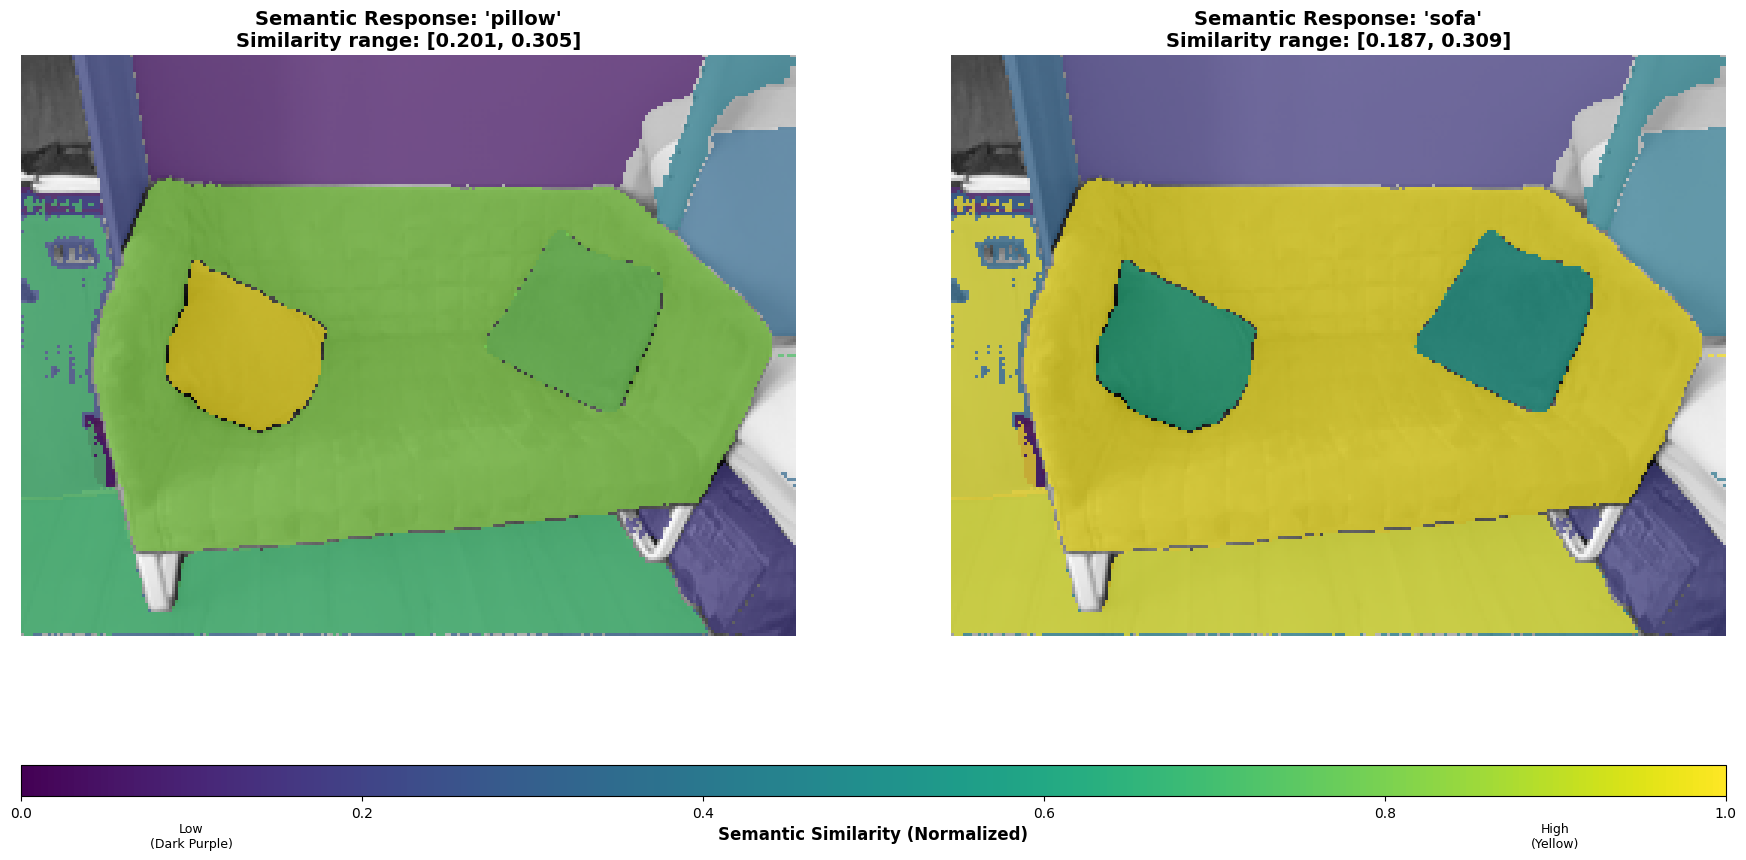


Semantic Similarity Analysis:
  'pillow': mean=0.242, max=0.305, std=0.033
  'sofa': mean=0.239, max=0.309, std=0.036


In [18]:
example_results = visualize_level_a_example(
    config,
    frame_index=config.LEVEL_A_CONFIG['example_viz_index']
)

## 6. Semantic Voxel Grid
Implement the TODOs below

In [19]:
class SemanticVoxelGrid:
    """Voxel grid that stores CLIP embeddings for semantic querying."""
    def __init__(self, voxel_size: float = 0.1, feature_dim: int = 512):
        """Initialize semantic voxel grid."""
        self.voxel_size = voxel_size
        self.feature_dim = feature_dim
        self.voxel_features = {}
        self.voxel_counts = {}
        self.bounds_min = None
        self.bounds_max = None
            
    def world_to_voxel(self, points: np.ndarray) -> np.ndarray:
        """Convert world coordinates to voxel indices."""
        return np.floor(points / self.voxel_size).astype(int)

    def voxel_to_world(self, indices: np.ndarray) -> np.ndarray:
        """Convert voxel indices to world coordinates (center of voxel)."""
        return (indices + 0.5) * self.voxel_size

    def add_semantic_points(self, points: np.ndarray, features: np.ndarray):
        """Add points with semantic features to the voxel grid."""
        if len(points) == 0:
            return
        
        # Update bounds
        if self.bounds_min is None:
            self.bounds_min = np.min(points, axis=0)
            self.bounds_max = np.max(points, axis=0)
        else:
            self.bounds_min = np.minimum(self.bounds_min, np.min(points, axis=0))
            self.bounds_max = np.maximum(self.bounds_max, np.max(points, axis=0))
        
        # Convert to voxel indices
        voxel_indices = self.world_to_voxel(points)
        
        # Group points by voxel
        unique_voxels = np.unique(voxel_indices, axis=0)
        
        for voxel_idx in unique_voxels:
            voxel_key = tuple(voxel_idx)
            
            if voxel_key not in self.voxel_features:
                self.voxel_features[voxel_key] = np.zeros(self.feature_dim)
                self.voxel_counts[voxel_key] = 0
            
            # Running average of features
            self.voxel_features[voxel_key] += features
            self.voxel_counts[voxel_key] += 1

    def get_normalized_features(self) -> Dict:
        """Get normalized average features for each voxel."""
        normalized = {}
        for voxel_key, features in self.voxel_features.items():
            count = self.voxel_counts[voxel_key]
            if count > 0:
                avg_features = features / count
                avg_features = avg_features / (np.linalg.norm(avg_features) + 1e-6)
                normalized[voxel_key] = avg_features
        return normalized

    def query_text(self, text_query: str, clip_model, clip_processor, device: str) -> tuple:
        """Query the voxel grid with text and return similarity scores."""
        # Encode text query
        inputs = clip_processor(text=[text_query], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            text_features = clip_model.get_text_features(**inputs)

            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        text_features = text_features.cpu().numpy().squeeze()
        
        # Compute similarities
        normalized_features = self.get_normalized_features()
        
        if not normalized_features:
            return np.array([]), np.array([])
        
        # ============================================================================
        # NON-VECTORIZED IMPLEMENTATION (PROVIDED AS REFERENCE)
        # This implementation uses a for loop to compute cosine similarities
        # ============================================================================
        voxel_centers_loop = []
        similarities_loop = []
        
        for voxel_key, voxel_features in normalized_features.items():
            # Compute cosine similarity using dot product (features are already normalized)
            similarity = np.dot(text_features, voxel_features)
            voxel_center = self.voxel_to_world(np.array(voxel_key))
            voxel_centers_loop.append(voxel_center)
            similarities_loop.append(similarity)
        
        voxel_centers_loop = np.array(voxel_centers_loop)
        similarities_loop = np.array(similarities_loop)
        
        # ============================================================================
        # TODO 1: VECTORIZED IMPLEMENTATION
        # Task: Implement a vectorized version that avoids the for loop above.
        # 
        # Hints:
        # 1. Extract all voxel keys and features into numpy arrays
        # 2. Use matrix multiplication (@) for computing all similarities at once
        # 3. Convert voxel indices to world coordinates in a vectorized manner
        #
        # Your implementation should compute:
        # - voxel_centers_vectorized: numpy array of shape (num_voxels, 3)
        # - similarities_vectorized: numpy array of shape (num_voxels,)
        # ============================================================================
        
        # Student implementation goes here
        voxel_keys = list(normalized_features.keys()) # Extract keys from normalized_features
        voxel_features_matrix = np.stack(
            [normalized_features[k] for k in voxel_keys], axis=0
            ) # Stack all feature vectors into a matrix
        voxel_indices = np.array(voxel_keys, dtype=int) # Convert keys to numpy array
        
        # Compute all similarities at once using matrix multiplication
        similarities_vectorized = voxel_features_matrix @ text_features
        
        # Transform all voxel indices to world coordinates at once
        voxel_centers_vectorized = self.voxel_to_world(voxel_indices) # Use self.voxel_to_world()
        
        # ============================================================================
        # VERIFICATION: Check if both implementations produce the same results
        # ============================================================================
        if voxel_centers_vectorized is not None and similarities_vectorized is not None:
            # Check if the results match (allowing for small numerical differences)
            centers_match = np.allclose(voxel_centers_loop, voxel_centers_vectorized, rtol=1e-5)
            similarities_match = np.allclose(similarities_loop, similarities_vectorized, rtol=1e-5)
            
            if centers_match and similarities_match:
                print("✓ Success! Vectorized implementation produces identical results.")
                print(f"  Processed {len(similarities_vectorized)} voxels")
            else:
                print("✗ Mismatch detected between implementations:")
                if not centers_match:
                    print("  - Voxel centers don't match")
                    print(f"    Max difference: {np.max(np.abs(voxel_centers_loop - voxel_centers_vectorized))}")
                if not similarities_match:
                    print("  - Similarities don't match")
                    print(f"    Max difference: {np.max(np.abs(similarities_loop - similarities_vectorized))}")
            
            # Return the vectorized version if available, otherwise fall back to loop version
            return voxel_centers_vectorized, similarities_vectorized
        else:
            print("⚠ Vectorized implementation not complete, using loop version")
            return voxel_centers_loop, similarities_loop

## 7. 3D Point Cloud Generation


In [20]:
def segment_to_3d_pointcloud(mask: np.ndarray,
                             depth_image: np.ndarray,
                             rgb_image: np.ndarray,
                             camera_intrinsics: np.ndarray,
                             camera_pose: np.ndarray,
                             depth_scale: float = 1000.0,
                             max_points: int = 5000,
                             min_depth: float = 0.1,
                             max_depth: float = 10.0) -> Optional[Dict]:
    """Convert segmented region to 3D point cloud."""
    # Get mask indices
    mask_indices = np.where(mask)
    
    if len(mask_indices[0]) == 0:
        return None
    
    # Extract depth values for masked region
    depths = depth_image[mask_indices] / depth_scale
    
    # Filter valid depths
    valid_mask = (depths > min_depth) & (depths < max_depth)
    if not np.any(valid_mask):
        return None
    
    # Get valid coordinates and depths
    v_coords = mask_indices[0][valid_mask]
    u_coords = mask_indices[1][valid_mask]
    valid_depths = depths[valid_mask]
    
    # Subsample if too many points
    num_points = len(v_coords)
    if num_points > max_points:
        indices = np.random.choice(num_points, max_points, replace=False)
        v_coords = v_coords[indices]
        u_coords = u_coords[indices]
        valid_depths = valid_depths[indices]
    
    # Get camera parameters
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]
    
    # Project to 3D camera coordinates
    x_cam = (u_coords - cx) * valid_depths / fx
    y_cam = (v_coords - cy) * valid_depths / fy
    z_cam = valid_depths
    
    # Stack into points
    points_cam = np.stack([x_cam, y_cam, z_cam], axis=-1)
    
    # Transform to world coordinates
    points_cam_hom = np.concatenate([points_cam, np.ones((len(points_cam), 1))], axis=1)
    camera_pose_inv = np.linalg.inv(camera_pose)
    points_world_hom = (camera_pose_inv @ points_cam_hom.T).T
    points_world = points_world_hom[:, :3]
    
    # Get colors if RGB image provided
    colors = None
    if rgb_image is not None:
        colors = rgb_image[v_coords, u_coords]
        if colors.dtype != np.uint8:
            colors = (colors * 255).astype(np.uint8)
    
    return {
        'points': points_world,
        'colors': colors,
        'camera_points': points_cam,
        'num_points': len(points_world)
    }

## 8. Frame Processing


In [21]:
def process_frame_level_a(frame_data: Dict,
        sam_model, sam_processor,
        clip_model, clip_processor,
        device: str,
        config: Config,
        grid_size: int = 6) -> Dict:
    """Process a single frame for Level A: SAM proposals + CLIP features."""
    results = {
    'frame_name': frame_data['frame_name'],
    'segments': [],
    'semantic_points': []
    }
    try:
        # Load images
        image = Image.open(frame_data['rgb_path']).convert("RGB")
        depth_image = cv2.imread(frame_data['depth_path'], cv2.IMREAD_UNCHANGED)
        rgb_image = np.array(image)
        
        # Generate SAM proposals
        proposals = generate_sam_proposals(
            image,
            sam_model,
            sam_processor,
            device,
            grid_size=grid_size,
            confidence_threshold=config.LEVEL_A_CONFIG['sam_confidence_threshold']
        )
        
        # Process each proposal
        for proposal in proposals:
            mask = proposal['mask']
            
            # Extract CLIP features
            clip_features = extract_clip_features_from_segment(
                image,
                mask,
                clip_model,
                clip_processor,
                device,
                padding_ratio=config.LEVEL_A_CONFIG['padding_ratio_image_crops'] 
            )
            
            if clip_features is None:
                continue
            
            # Convert to 3D points
            pc_data = segment_to_3d_pointcloud(
                mask,
                depth_image,
                rgb_image,
                frame_data['camera_intrinsics'],
                frame_data['camera_pose'],
                depth_scale=config.TSDF_CONFIG['depth_scale'],
                max_points=1000
            )
            
            if pc_data is None or pc_data['num_points'] < 10:
                continue
            
            results['segments'].append({
                'mask': mask,
                'area': proposal['area'],
                'confidence': proposal['confidence']
            })
            
            results['semantic_points'].append({
                'points': pc_data['points'],
                'features': clip_features,
                'frame_name': frame_data['frame_name']
            })
            
    except Exception as e:
        print(f"Error processing frame {frame_data['frame_name']}: {e}")

    return results


## 9. Full Pipeline Execution

Now let's run the complete semantic voxel mapping pipeline across all frames:

In [22]:
def run_level_a_pipeline(config: Config,
                        max_frames: int = 35,
                        voxel_size: float = 0.1,
                        grid_size: int = 6,
                        frame_skip_level_a: int = 7) -> Dict:
    """Run Level A pipeline: SAM + CLIP for semantic voxel mapping."""
    
    # Load models
    print("Loading models...")
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    clip_model, clip_processor, _ = load_clip_model(device=device)
    
    # Get CLIP feature dimension
    dummy_input = clip_processor(images=Image.new('RGB', (224, 224)), return_tensors="pt")
    dummy_input = {k: v.to(device) for k, v in dummy_input.items()}
    with torch.no_grad():
        dummy_features = clip_model.get_image_features(**dummy_input)
    feature_dim = dummy_features.shape[-1]
    print(f"CLIP feature dimension: {feature_dim}")
    
    # Load camera data
    camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
    
    # Get frames with Level A specific frame skip
    frames_metadata = get_frame_list(config.RGB_PATH, frame_skip_level_a)
    print(f"Selected {len(frames_metadata)} frames with frame skip of {frame_skip_level_a}")
    
    # Align frames
    aligned_frames = validate_and_align_frame_data(
        frames_metadata,
        camera_poses,
        config.RGB_PATH,
        config.DEPTH_PATH,
        config.INTRINSICS_PATH
    )
    
    if not aligned_frames:
        print("No aligned frames found!")
        return {}
    
    # Create semantic voxel grid
    voxel_grid = SemanticVoxelGrid(voxel_size=voxel_size, feature_dim=feature_dim)
    
    # Process frames
    frames_to_process = aligned_frames[:max_frames]
    print(f"Processing {len(frames_to_process)} frames...")
    
    for frame_data in tqdm(frames_to_process, desc="Processing frames"):
        frame_results = process_frame_level_a(
            frame_data,
            sam_model, sam_processor,
            clip_model, clip_processor,
            device,
            config,
            grid_size=grid_size
        )
        
        # Add semantic points to voxel grid
        for semantic_data in frame_results['semantic_points']:
            voxel_grid.add_semantic_points(
                semantic_data['points'],
                semantic_data['features']
            )
    
    print(f"\nLevel A Results:")
    print(f"  Occupied voxels: {len(voxel_grid.voxel_features)}")
    
    return {
        'voxel_grid': voxel_grid,
        'clip_model': clip_model,
        'clip_processor': clip_processor,
        'device': device
    }

In [23]:
import numpy as np
import matplotlib.cm as cm

def render_voxel_similarity_from_pose(
    voxel_grid,
    pose,                 # 4x4, WORLD -> CAMERA extrinsic (do NOT invert)
    intrinsics,           # 3x3 K matrix (fx, 0, cx; 0, fy, cy; 0, 0, 1)
    clip_model,
    clip_processor,
    device,
    text_query="sofa",
    img_size=(192, 256),  # (H, W)
    point_radius=2,       # pixel radius to “splat” each voxel
    z_epsilon=1e-6,       # avoid div by zero
):
    # 1) Query voxel grid for this text
    #    (consistent with level_specific_viz.query_and_visualize_semantic_grid)
    voxel_centers, sim = voxel_grid.query_text(
        text_query, clip_model, clip_processor, device
    )  # voxel_centers: (N,3) in WORLD coords; sim: (N,)

    if len(voxel_centers) == 0:
        H, W = img_size
        return np.zeros((H, W, 3), dtype=np.uint8)

    voxel_centers = np.asarray(voxel_centers, dtype=np.float32)  # (N,3)
    sim = np.asarray(sim, dtype=np.float32)                      # (N,)

    # Normalize similarities to [0,1] for coloring
    smin, smax = float(sim.min()), float(sim.max())
    if smax > smin:
        sim_norm = (sim - smin) / (smax - smin)
    else:
        sim_norm = np.zeros_like(sim) + 0.5

    # 2) World -> Camera using the given extrinsic (world->camera)
    N = voxel_centers.shape[0]
    world_h = np.c_[voxel_centers, np.ones((N, 1), dtype=np.float32)]  # (N,4)
    cam_h = (pose @ world_h.T).T                                        # (N,4)
    Xc, Yc, Zc = cam_h[:, 0], cam_h[:, 1], cam_h[:, 2]

    # 3) Perspective projection
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]

    # Keep points in front of the camera
    front = Zc > z_epsilon
    Xc, Yc, Zc, sim_norm = Xc[front], Yc[front], Zc[front], sim_norm[front]

    if Xc.size == 0:
        H, W = img_size
        return np.zeros((H, W, 3), dtype=np.uint8)

    u = fx * (Xc / Zc) + cx
    v = fy * (Yc / Zc) + cy

    # 4) Rasterize with a simple z-buffer and colormap
    H, W = img_size
    img = np.zeros((H, W, 3), dtype=np.uint8)
    zbuf = np.full((H, W), np.inf, dtype=np.float32)

    # colormap in [0,1] -> RGBA
    viridis = cm.get_cmap("viridis")

    # Round to pixels
    ui = np.rint(u).astype(int)
    vi = np.rint(v).astype(int)

    in_bounds = (ui >= 0) & (ui < W) & (vi >= 0) & (vi < H)
    ui, vi, Zc, sim_norm = ui[in_bounds], vi[in_bounds], Zc[in_bounds], sim_norm[in_bounds]

    # Optional splatting
    r = max(0, int(point_radius))
    for px, py, z, s in zip(ui, vi, Zc, sim_norm):
        # small disk around (px,py)
        x0, x1 = max(0, px - r), min(W - 1, px + r)
        y0, y1 = max(0, py - r), min(H - 1, py + r)
        for yy in range(y0, y1 + 1):
            for xx in range(x0, x1 + 1):
                # z-test
                if z < zbuf[yy, xx]:
                    zbuf[yy, xx] = z
                    rgba = viridis(float(s))  # (r,g,b,a) in 0..1
                    img[yy, xx] = (np.array(rgba[:3]) * 255).astype(np.uint8)

    return img



FULL PIPELINE EXECUTION
Loading models...
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
CLIP feature dimension: 512
Loaded 540 camera poses
Selected 78 frames from 540 total
Selected 78 frames with frame skip of 7
Validating and aligning 78 frames...
Aligned 78 frames (skipped 0)
Processing 40 frames...


Processing frames:   0%|          | 0/40 [00:00<?, ?it/s]

Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 8 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 6 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 8 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 10 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 10 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 14 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 16 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Genera

/tmp/ipykernel_18228/3779029129.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


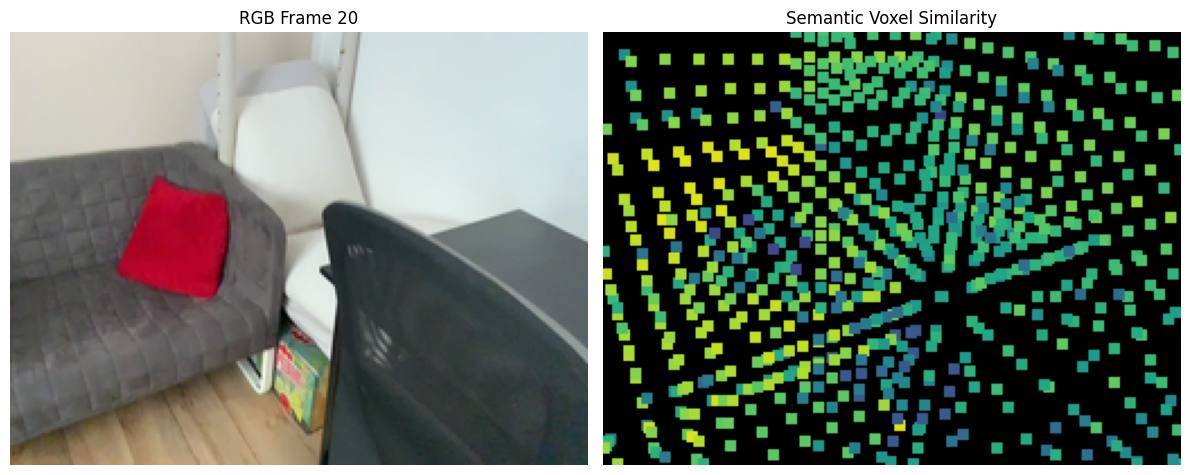

In [24]:
import matplotlib.pyplot as plt

# Example usage:
results = run_full_pipeline(config)
voxel_grid = results["voxel_grid"]
clip_model = results["clip_model"]
clip_processor = results["clip_processor"]
device = results["device"]


from lab_utils.data_utils import (
    load_camera_poses,
    get_frame_list,
    validate_and_align_frame_data,
)

# 1. Load raw data
camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
frames = get_frame_list(config.RGB_PATH, config.LEVEL_A_CONFIG['frame_skip'])

# 2. Align all frames (uses closest pose + intrinsics)
aligned_frames = validate_and_align_frame_data(
    frames, camera_poses,
    config.RGB_PATH,
    config.DEPTH_PATH,
    config.INTRINSICS_PATH
)

# 3. Pick a frame
frame_idx = 20
frame_data = aligned_frames[frame_idx]
pose = frame_data['camera_pose']
intrinsics = frame_data['camera_intrinsics']

# 4. Render
rendered = render_voxel_similarity_from_pose(
    voxel_grid,
    pose,
    intrinsics,
    clip_model,
    clip_processor,
    device,
    text_query="wall"  # or any label you want
)
# Load RGB image
rgb_path = frame_data['rgb_path']
rgb_image = Image.open(rgb_path)

# Plot side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title(f"RGB Frame {frame_idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rendered)
plt.title("Semantic Voxel Similarity")
plt.axis("off")

plt.tight_layout()
plt.show()

## 10. Complete pipeline

This notebook demonstrates the complete Level A pipeline: SAM + CLIP semantic voxel mapping.

In [ ]:
# Execute the complete semantic voxel mapping pipeline
print("Running full SAM + CLIP semantic mapping pipeline...")

pipeline_results = run_full_pipeline(config)

print(f"\n{'='*60}")
print(f"LEVEL A EXECUTION COMPLETE")
print(f"{'='*60}")

## 11. Interactive Semantic Querying

Now you can query the semantic voxel grid with natural language! Try different queries to find objects in 3D space.

In [ ]:
# Interactive querying - you can modify the query and run this cell multiple times
if 'pipeline_results' in locals() and pipeline_results and 'voxel_grid' in pipeline_results:
    # ============================================
    # MODIFY THIS QUERY TO SEARCH FOR DIFFERENT OBJECTS
    # ============================================
    query = "sofa"  # Try: "bed", "pillow", "shelf", "table", "sofa", "chair", etc.
                       # You can also try abstract prompts like "a place to sit"
    
    # Use the environment point cloud from pipeline results
    environment_pcd = pipeline_results.get('environment_pcd')
    
    print(f"Querying semantic voxel grid for: '{query}'")
    query_and_visualize_semantic_grid(
        pipeline_results,
        query,
        environment_pcd,
        config
    )
else:
    print("Pipeline results not available. Run the pipeline execution cell above first.")